# Image viewer

This notebook is for inspecting timelapse microscopy data, with associated sinhgle-cell labels and tracks, showing the infection of human macrophages with Mycobacterium Tuberculosis (Mtb), acquired on an Opera Phenix confocal microscope. 

In [1]:
import napari
from macrohet import dataio, tile
import btrack
import os

### Load experiment of choice

The Opera Phenix is a high-throughput confocal microscope that acquires very large 5-dimensional (TCZXY) images over several fields of view in any one experiment. Therefore, a lazy-loading approach is chosen to mosaic, view and annotate these images. This approach depends upon Dask and DaskFusion. The first step is to load the main metadata file (typically called `Index.idx.xml` and located in the main `Images` directory) that contains the image filenames and associated TCXZY information used to organise the images.

In [18]:
base_dir = '/mnt/DATA/macrohet/'
# base_dir = '/Volumes/lab-gutierrezm/home/users/dayn/macrohet_nemo/'
metadata_fn = os.path.join(base_dir, 'macrohet_images/Index.idx.xml')
metadata = dataio.read_harmony_metadata(metadata_fn)  
metadata

Reading metadata XML file...


Extracting HarmonyV5 metadata:   0%|          | 0/113400 [00:00<?, ?it/s]

Extracting metadata complete!


,id,State,URL,Row,Col,FieldID,PlaneID,TimepointID,ChannelID,FlimID,...,PositionZ,AbsPositionZ,MeasurementTimeOffset,AbsTime,MainExcitationWavelength,MainEmissionWavelength,ObjectiveMagnification,ObjectiveNA,ExposureTime,OrientationMatrix
0,0303K1F1P1R1,Ok,r03c03f01p01-ch1sk1fk1fl1.tiff,3,3,1,1,0,1,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
1,0303K1F1P1R2,Ok,r03c03f01p01-ch2sk1fk1fl1.tiff,3,3,1,1,0,2,1,...,0,0.135583505,0,2021-04-16T19:09:33.84+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
2,0303K1F1P2R1,Ok,r03c03f01p02-ch1sk1fk1fl1.tiff,3,3,1,2,0,1,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
3,0303K1F1P2R2,Ok,r03c03f01p02-ch2sk1fk1fl1.tiff,3,3,1,2,0,2,1,...,2E-06,0.135585502,0,2021-04-16T19:09:34.12+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
4,0303K1F1P3R1,Ok,r03c03f01p03-ch1sk1fk1fl1.tiff,3,3,1,3,0,1,1,...,4E-06,0.135587499,0,2021-04-16T19:09:34.4+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113395,0609K75F9P1R2,Ok,r06c09f09p01-ch2sk75fk1fl1.tiff,6,9,9,1,74,2,1,...,0,0.135533601,266399.61,2021-04-19T21:14:19.477+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113396,0609K75F9P2R1,Ok,r06c09f09p02-ch1sk75fk1fl1.tiff,6,9,9,2,74,1,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113397,0609K75F9P2R2,Ok,r06c09f09p02-ch2sk75fk1fl1.tiff,6,9,9,2,74,2,1,...,2E-06,0.135535598,266399.61,2021-04-19T21:14:19.757+01:00,640,706,40,1.1,0.2,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."
113398,0609K75F9P3R1,Ok,r06c09f09p03-ch1sk75fk1fl1.tiff,6,9,9,3,74,1,1,...,4E-06,0.135537595,266399.61,2021-04-19T21:14:20.037+01:00,488,522,40,1.1,0.1,"[[0.990860,0,0,-15.9],[0,-0.990860,0,-44.8],[0..."


### View assay layout and mask information (optional)

The Opera Phenix acquires many time lapse series from a range of positions. The first step is to inspect the image metadata, presented in the form of an `Assaylayout/experiment_ID.xml` file, to show which positions correspond to which experimental assays.

In [4]:
metadata_path = os.path.join(base_dir, 'macrohet_images/Assaylayout/20210602_Live_cell_IPSDMGFP_ATB.xml')
assay_layout = dataio.read_harmony_metadata(metadata_path, assay_layout=True,)# mask_exist=True,  image_dir = image_dir, image_metadata = metadata)
assay_layout

Reading metadata XML file...
Extracting metadata complete!


Strain Compound Concentration ConcentrationEC
3 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
4 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA            60            EC50
  7     WT      RIF           0.1            EC50
  8     WT      INH          0.04            EC50
  9     WT      BDQ          0.02            EC50
5 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99
6 4    RD1     CTRL             0             EC0
  5     WT     CTRL             0             EC0
  6     WT      PZA           400            EC99
  7     WT      RIF             2            EC99
  8     WT      INH             2            EC99
  9     WT      BDQ           2.5            EC99

### Define row and column of choice

In [5]:
row = 3
column = 5

### Now to lazily mosaic the images using Dask prior to viewing them.

1x (75,2,3) [TCZ] image stack takes approximately 1 minute to stitch together, so only load the one field of view I want.

In [6]:
image_dir = os.path.join(base_dir, 'macrohet_images/Images_8bit')
images = tile.compile_mosaic(image_dir, 
                             metadata, 
                             row, column, 
                             set_plane=1,#'sum_proj',
#                              set_channel=1,
#                              set_time = 66,
#                             input_transforms = [input_transforms]
                            )#.compute().compute()

In [ ]:
%%time
images = images.compute().compute()

# Load tracks

In [20]:
tracks_fn = os.path.join(base_dir, f'labels/full_localisation/{row,column}_objs_masks_tracks.h5')
with btrack.io.HDF5FileHandler(tracks_fn, 'r') as hdf:
    tracks = hdf.tracks
    segmentation = hdf.segmentation
napari_tracks, properties, graph = btrack.utils.tracks_to_napari(tracks, ndim=2)

[INFO][2023/04/26 03:08:45 PM] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3, 5)_objs_masks_tracks.h5...
[INFO][2023/04/26 03:08:45 PM] Loading tracks/obj_type_1
[INFO][2023/04/26 03:08:45 PM] Loading objects/obj_type_1 (31313, 5) (31313 filtered: None)
[INFO][2023/04/26 03:09:04 PM] Loading segmentation (75, 6048, 6048)
[INFO][2023/04/26 03:09:04 PM] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/(3, 5)_objs_masks_tracks.h5


### Load downscaled version

In [60]:
tracks_fn = os.path.join(base_dir, f'labels/full_localisation/downscaled/{row,column}_downsc_objs_masks_tracks.h5')
with btrack.dataio.HDF5FileHandler(tracks_fn, 'r') as hdf:
    ds_tracks = hdf.tracks
    ds_segmentation = hdf.segmentation
ds_napari_tracks, properties, graph = btrack.utils.tracks_to_napari(ds_tracks, ndim=2)

[INFO][2023/04/27 03:33:45 pm] Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5...
27-Apr-23 15:33:45 - btrack.dataio - INFO     - Opening HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5...
[INFO][2023/04/27 03:33:45 pm] Loading tracks/obj_type_1
27-Apr-23 15:33:45 - btrack.dataio - INFO     - Loading tracks/obj_type_1
[INFO][2023/04/27 03:33:45 pm] Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
27-Apr-23 15:33:45 - btrack.dataio - INFO     - Loading objects/obj_type_1 (26917, 5) (26917 filtered: None)
[INFO][2023/04/27 03:33:46 pm] Loading segmentation (75, 1200, 1200)
27-Apr-23 15:33:46 - btrack.dataio - INFO     - Loading segmentation (75, 1200, 1200)
[INFO][2023/04/27 03:33:46 pm] Closing HDF file: /mnt/DATA/macrohet/labels/full_localisation/downscaled/(3, 5)_downsc_objs_masks_tracks.h5
27-Apr-23 15:33:46 - btrack.dataio - INFO     - Closing HDF file: /mnt/DA

In [13]:
ds_napari_tracks_75, properties_75, graph_75 = btrack.utils.tracks_to_napari([track for track in ds_tracks if len(track) >= 74], ndim=2)

### Recolour tracks

In [61]:
ds_col_segmentation = btrack.utils.update_segmentation(ds_segmentation, ds_tracks,)

# Launch napari image viewer

In [55]:
color_dict = dict([(i, 'cyan') for i in range(1, segmentation[0].max())])
viewer = napari.Viewer()

viewer.add_labels(segmentation[0], num_colors = 1, color = color_dict).contour = 10
                  #scale=(10, 1, 1,), 
                  #color='yellow'
#                  )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [56]:
viewer.add_image(images[0], 
                 channel_axis=0,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
                 contrast_limits=[[0,450], [0,450]], 
                 visible = False
                 )

[<Image layer 'macrophage' at 0x7f71498ef760>,
 <Image layer 'mtb' at 0x7f714720e400>]

Rendering frames...


100%|█████████████████████████████████████████████████████████████████| 401/401 [1:11:16<00:00, 10.66s/it]


In [71]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
#                  contrast_limits=[[100, 6000], [100, 2000]],
                 contrast_limits=[[0,450], [0,450]], 
                 visible = False
                 )
viewer.add_labels(segmentation, 
                  #scale=(10, 1, 1,), 
                  #color='yellow'
                 )
# viewer.add_tracks(napari_tracks,
# #                     properties=properties, 
# #                     graph=graph, 
# #                     name="Tracks [5,4]", 
#                     blending="translucent",
#                     visible=True,
# #                     scale = (100,1,1)
# #                 )
viewer.add_tracks(ds_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
                    scale = (1,1,1)
                )

viewer.add_labels(ds_col_segmentation, 
                  scale=(1, 1, 1,), 
#                   color={1:'yellow'}
                 )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'ds_col_segmentation' at 0x7f713d007b80>

In [73]:
viewer = napari.Viewer()

viewer.add_image(images, 
                 channel_axis=1,
                 name=["macrophage", "mtb"],
                 colormap=["green",  "magenta"],
#                  contrast_limits=[[100, 6000], [100, 2000]],
                 contrast_limits=[[0,450], [0,450]], 
                 visible = False
                 )
viewer.add_labels(segmentation, 
                  #scale=(10, 1, 1,), 
                  #color='yellow'
                 )
# viewer.add_tracks(napari_tracks,
# #                     properties=properties, 
# #                     graph=graph, 
# #                     name="Tracks [5,4]", 
#                     blending="translucent",
#                     visible=True,
# #                     scale = (100,1,1)
# #                 )
viewer.add_tracks(ds_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
                    scale = (1,1,1)
                )

viewer.add_labels(ds_col_segmentation, 
                  scale=(1, 1, 1,), 
#                   color={1:'yellow'}
                 )

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'ds_col_segmentation' at 0x7f713fdd1250>

In [63]:
from macrohet import visualise

In [76]:
napari_tracks_us = visualise.scale_napari_tracks(ds_napari_tracks)

In [83]:
tracker_layer = viewer.add_tracks(napari_tracks_us,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
                    scale = (1,1,1)
                )

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/widgets/qt_viewer_dock_widget.py", line 230, in keyPressEvent
    return self._ref_qt_viewer().keyPressEvent(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py", line 1123, in keyPressEvent
    self.canvas._backend._keyEvent(self.canvas.events.key_press, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/visp

In [87]:
output_dir = '/mnt/DATA/macrohet/results/Mtb_thresholding/3,5'
@viewer.bind_key('p', overwrite=True)
def Mtb_pos(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in ds_tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-1'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "Mtb_positive.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "Mtb_positive_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")
@viewer.bind_key('n', overwrite=True)
def Mtb_neg(event=None):
    ### extract cell ID under cursor
    cell_ID = tracker_layer._get_value(position=viewer.cursor.position)
    ### get time frame
    time = viewer.cursor.position[0]
    try:
        positive_track = [track for track in ds_tracks if track.ID == cell_ID][0]
    except:
        print('Looks like there was no identifiable track there')
    ### get index of cell instance of selected frame
    cell_index = positive_track.t.index(time)
    ### extract the pixel intensity of that segment
    px_int =  positive_track['mean_intensity-1'][cell_index]
    ### write to output file
    with open(os.path.join(output_dir, "Mtb_negative.csv"),"a") as f:
        f.write(f"{px_int}\n")
    with open(os.path.join(output_dir, "Mtb_negative_details.csv"),"a") as f:
        f.write(f"{cell_ID, time, px_int}\n")

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

Looks like there was no identifiable track there


Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 561, in keyPressEvent
    self._keyEvent(self._vispy_canvas.events.key_press, ev)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 622, in _keyEvent
    func(native=ev, key=key, text=str(ev.text()), modifiers=mod)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/utils/key_bindings.py", line 545, in on_key_press
    self.press_key(

# Assessing manual thresholding

In [111]:
import pandas as pd

# Load positive values CSV file into a pandas dataframe
df_pos = pd.read_csv('/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/Mtb_positive.csv', header=None, names=['Mean Pixel Value'])
# Add a new column 'label' with value 'positive'
df_pos['label'] = 'positive'

# Load negative values CSV file into a pandas dataframe
df_neg = pd.read_csv('/mnt/DATA/macrohet/results/Mtb_thresholding/3,5/Mtb_negative.csv', header=None, names=['Mean Pixel Value'])
# Add a new column 'label' with value 'negative'
df_neg['label'] = 'negative'

# Concatenate the positive and negative dataframes vertically
df = pd.concat([df_pos, df_neg], axis=0)

# Reset the index of the merged dataframe
df.reset_index(drop=True, inplace=True)


In [110]:
df

,Mean Pixel Value,label
0,0.005529449786990881),positive
1,0.0057788193),positive
2,0.005650498438626528),positive
3,0.0058266907),positive
4,0.005577918607741594),positive
...,...,...
496,0.005580566357821226),negative
497,0.005768332164734602),negative
498,0.006076629),negative
499,0.00574325118213892),negative


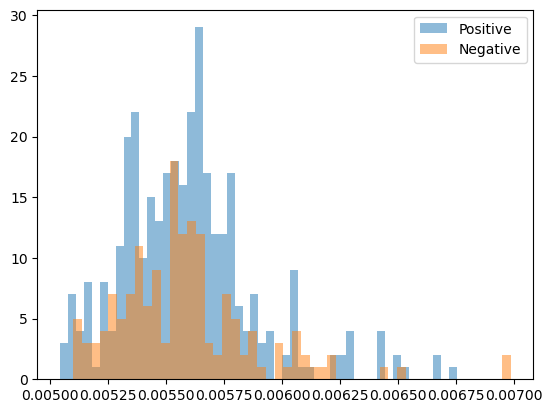

In [101]:
import matplotlib.pyplot as plt

# Separate the positive and negative values into separate dataframes
df_pos = df[df['label'] == 'positive']
df_neg = df[df['label'] == 'negative']

# Plot the histograms
plt.hist(df_pos['Mean Pixel Value'], bins=50, alpha=0.5, label='Positive')
plt.hist(df_neg['Mean Pixel Value'], bins=50, alpha=0.5, label='Negative')
plt.legend(loc='upper right')
plt.show()


# WTF

These should not be overlapping at all!

In [113]:
# positive
0.005319*2727.0

14.504913

In [112]:
[track for track in ds_tracks if track.ID == 107][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-1,orientation,minor_axis_length,major_axis_length,mean_intensity-0,area
0,107,0,365.268799,738.155823,0.000000,107,107,5,0,False,0.005319,0.115770,38.825630,93.623444,0.015798,2727.0
1,107,1,367.082611,736.544678,0.000000,107,107,5,0,False,0.005475,0.038472,40.734158,84.906563,0.025713,2651.0
2,107,2,366.511169,728.545471,0.000000,107,107,5,0,False,0.005327,0.130810,39.189754,85.881912,0.018786,2594.0
3,107,3,369.753815,737.994995,0.000000,107,107,5,0,False,0.005431,0.145877,39.751923,107.949440,0.014775,3205.0
4,107,4,369.639709,727.253967,0.000000,107,107,5,0,False,0.005478,0.149986,44.991356,92.644508,0.022930,3103.0
5,107,5,370.064880,727.390198,0.000000,107,107,5,0,False,0.005350,0.138099,43.756714,92.559929,0.017125,3037.0
6,107,6,372.399994,739.966980,0.000000,107,107,5,0,False,0.005399,0.261037,38.487091,107.412918,0.016937,3150.0
7,107,7,372.241577,732.012512,0.000000,107,107,5,0,False,0.005620,0.169895,44.562943,92.180237,0.025869,3121.0
8,107,8,372.437897,733.931946,0.000000,107,107,5,0,False,0.005346,0.225747,38.611256,84.933983,0.016131,2528.0
9,107,9,369.955475,730.986145,0.000000,107,107,5,0,False,0.005298,0.230602,38.938202,76.465851,0.015972,2313.0


In [115]:
# negative
0.005704*3695.0

21.07628

In [114]:
[track for track in ds_tracks if track.ID == 217][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-1,orientation,minor_axis_length,major_axis_length,mean_intensity-0,area
0,217,0,578.715027,1011.727722,0.000000,217,217,5,0,False,0.005704,0.140729,41.576057,126.416893,0.019267,3695.0
1,217,1,581.060852,1008.681213,0.000000,217,217,5,0,False,0.005695,0.189639,43.869507,112.548172,0.018480,3614.0
2,217,2,582.096741,1003.270935,0.000000,217,217,5,0,False,0.005710,0.243580,45.144596,104.108170,0.020186,3514.0
3,217,3,583.258118,1010.244202,0.000000,217,217,5,0,False,0.005819,0.211802,53.526619,116.313179,0.023166,4312.0
4,217,4,586.542419,1012.792542,0.000000,217,217,5,0,False,0.005797,0.309949,45.945793,117.981773,0.030012,4150.0
5,217,5,583.991821,1008.830688,0.000000,217,217,5,0,False,0.005784,0.251723,51.616852,110.433151,0.026846,4170.0
6,217,6,584.874023,1007.612183,0.000000,217,217,5,0,False,0.005812,0.319046,49.063728,94.756790,0.036833,3476.0
7,217,7,584.612305,1006.478027,0.000000,217,217,5,0,False,0.005886,0.358646,49.272350,107.446709,0.040552,4052.0
8,217,8,585.264160,1009.007446,0.000000,217,217,5,0,False,0.005874,0.271223,49.497551,118.203018,0.040277,4179.0
9,217,9,586.288696,1010.124817,0.811346,217,217,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN


In [107]:
[track for track in ds_tracks if track.ID == 79][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-1,orientation,minor_axis_length,major_axis_length,mean_intensity-0,area
0,79,0,405.096741,661.642944,0.0,79,79,5,0,False,0.005259,-0.234213,41.024811,68.181740,0.010963,2078.0
1,79,1,417.257568,657.554138,0.0,79,79,5,0,False,0.005261,-0.610165,54.426769,61.265999,0.011438,2539.0
2,79,2,413.823608,653.859436,0.0,79,79,5,0,False,0.005234,-0.545834,40.804714,74.818054,0.009690,2092.0
3,79,3,403.272766,648.573364,0.0,79,79,5,0,False,0.005273,-1.046943,45.758255,58.682373,0.014422,1943.0
4,79,4,402.711639,647.511963,0.0,79,79,5,0,False,0.005255,-0.447861,39.851101,54.151627,0.008504,1668.0


In [106]:
# check actual sc values to make sure my key binding is recording correctly
[track for track in ds_tracks if track.ID == 111][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-1,orientation,minor_axis_length,major_axis_length,mean_intensity-0,area
0,111,0,438.224304,731.787720,0.0,111,111,5,0,False,0.005372,-1.312020,85.775986,140.107605,0.020314,8315.0
1,111,1,441.777435,733.336548,0.0,111,111,5,0,False,0.005347,-1.180230,97.534210,139.778976,0.015720,9166.0
2,111,2,443.500946,734.693359,0.0,111,111,5,0,False,0.005430,-1.112728,97.232941,142.356522,0.021089,9101.0
3,111,3,436.662201,737.334473,0.0,111,111,5,0,False,0.005397,-0.674610,96.179787,119.817039,0.022782,8706.0
4,111,4,445.994354,743.013428,0.0,111,111,5,0,False,0.005366,-0.967415,114.740089,128.790482,0.019553,10776.0
5,111,5,439.265259,739.460815,0.0,111,111,5,0,False,0.005345,-0.764085,96.281273,134.113754,0.017617,9281.0
6,111,6,445.329132,739.207153,0.0,111,111,5,0,False,0.005430,-0.934560,97.010971,147.398376,0.020223,9258.0
7,111,7,442.725800,740.979614,0.0,111,111,5,0,False,0.005413,-0.788488,93.438698,131.758911,0.019346,8483.0
8,111,8,448.311035,738.573792,0.0,111,111,5,0,False,0.005434,-0.995769,94.626205,157.274857,0.020737,9308.0
9,111,9,447.521118,740.525635,0.0,111,111,5,0,False,0.005448,-0.973541,94.051582,136.789978,0.018107,8593.0


In [103]:
# check actual sc values to make sure my key binding is recording correctly
[track for track in ds_tracks if track.ID == 172][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-1,orientation,minor_axis_length,major_axis_length,mean_intensity-0,area
0,172,0,692.441528,988.446045,0.000000,172,172,5,0,False,0.005635,-0.271672,43.981178,95.681252,0.019432,3112.0
1,172,1,698.228027,982.639221,0.000000,172,172,5,0,False,0.005683,-0.161277,43.554256,98.553925,0.024035,3193.0
2,172,2,700.945129,978.888733,0.000000,172,172,5,0,False,0.005637,-0.102721,40.969196,109.757942,0.020083,3262.0
3,172,3,703.352966,973.739014,0.000000,172,172,5,0,False,0.005703,-0.010441,39.659637,101.279144,0.027074,3054.0
4,172,4,704.623596,967.906616,0.000000,172,172,5,0,False,0.005662,0.029193,39.261276,104.353966,0.022527,3042.0
5,172,5,704.046753,966.006897,0.000000,172,172,5,0,False,0.005728,0.035159,32.541325,110.358833,0.023908,2758.0
6,172,6,704.647156,962.908569,0.000000,172,172,5,0,False,0.005703,0.095653,34.409283,102.139839,0.027514,2647.0
7,172,7,704.287537,958.082886,0.000000,172,172,5,0,False,0.005665,0.128618,39.202637,117.130890,0.021424,3245.0
8,172,8,705.985168,952.880554,0.000000,172,172,5,0,False,0.005748,0.170774,40.184978,102.140068,0.020745,3039.0
9,172,9,706.681885,948.532471,0.065389,172,172,5,0,True,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
692.441528*5.04, 988.446045*5.04

(3489.90530112, 4981.7680668)

In [105]:
[track for track in ds_tracks if track.ID == 202][0]

,ID,t,x,y,z,parent,root,state,generation,dummy,mean_intensity-1,orientation,minor_axis_length,major_axis_length,mean_intensity-0,area
0,202,0,776.826355,1008.487671,0.0,202,202,5,0,False,0.005585,1.246620,27.332590,32.421856,0.032436,691.0
1,202,1,776.991150,1004.545776,0.0,202,202,5,0,False,0.005471,-0.360638,30.910311,37.639469,0.041793,907.0


In [99]:
import seaborn as sns

In [ ]:
sns.relplot(data = df, hue = )

# Misc:

Downscale images, binarise masks, filter tracks

In [42]:
for i in [20, 40, 60, 80]:
    viewer.add_tracks(btrack.utils.tracks_to_napari([track for track in ds_tracks if len(track) < i],ndim=2)[0], 
                      name = i,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
                    scale = (10,1,1)
                )

In [24]:
import numpy as np
from skimage.morphology import square, binary_erosion, remove_small_objects
from tqdm.auto import tqdm

In [58]:
viewer.add_tracks(ds_napari_tracks,
#                     properties=properties, 
#                     graph=graph, 
#                     name="Tracks [5,4]", 
                    blending="translucent",
                    visible=True,
                    scale = (10,1,1)
                )

NameError: name 'ds_napari_tracks' is not defined

In [51]:
binary_masks = np.zeros(masks.shape, dtype = np.uint8)
for n, mask in tqdm(enumerate(masks), 
                 total = len(masks), 
                 desc = 'Progress through mask stack'):
#     binary_mask = np.zeros(mask.shape, dtype = np.uint8)
    binary_mask = binary_erosion(mask, square(2))
#     mask = remove_small_objects(mask, min_size=500)
#     for segment_ID in tqdm(range(1, np.max(mask)), 
#                            total = np.max(mask), 
#                            desc = 'Progress through number of segments', 
#                            leave = False):
#         segment = mask == segment_ID 
#         eroded_segment = binary_erosion(segment, square(5))
#         binary_mask += eroded_segment.astype(np.uint8)
    binary_masks[n] = binary_mask.astype(np.uint8) 

Progress through mask stack:   0%|          | 0/75 [00:00<?, ?it/s]

##### Downscale final image

In [61]:
from skimage.transform import rescale, resize, downscale_local_mean

In [60]:
final_frame = images[-1].compute().compute()

In [62]:
gfp = final_frame[0]
rfp = final_frame[1]
gfp_images_resized = list()
for t in tqdm(range(len(gfp)), 
              desc = f'Resizing GFP images in position {row, column}', leave = False):
    gfp_image_resized = rescale(gfp[t], 1200/6048, anti_aliasing=False)
    gfp_images_resized.append(gfp_image_resized)
gfp_images_resized = np.stack(gfp_images_resized, axis = 0)
rfp_images_resized = list()
for t in tqdm(range(len(rfp)),  
              desc = f'Resizing RFP images in position {row, column}', leave = False):
    rfp_image_resized = rescale(rfp[t], 1200/6048, anti_aliasing=False)
    rfp_images_resized.append(rfp_image_resized)
rfp_images_resized = np.stack(rfp_images_resized, axis = 0)
### stack together resized images for localisation
resized_images = np.stack([gfp_images_resized,rfp_images_resized], axis = -1)

Resizing GFP images in position ('5', '4'):   0%|          | 0/1 [00:00<?, ?it/s]

Resizing RFP images in position ('5', '4'):   0%|          | 0/1 [00:00<?, ?it/s]

In [64]:
resized_images.shape

(1, 1200, 1200, 2)